# Applied Deep Learning : Final Project

**Name**: Sahil Arora 

**Matriculation Number**: 32953


# Transfer Learning for Object Classification 

## Introduction
In this juypter notebook, you fill the source code, algorithm, description of data processing steps, results and visualizations on the task of Bee Classification. This project is a part of course 'Advanced Deep Learning' at Hochschule Ravensburg-Weingarten. The project is divided into 7 chapters as explained below:

1. Understanding the dataset.
2. Setting up training and validation Pipelines.
3. Setting up Model with base as VGG16 Convolutional Neural Network.
4. Training the Model from Chapter 3 using Transfer Learning.
5. Setting up a fully trainable model of VGG16 size.
6. Training the Model from scratch.
7. Comparing the results of Transfer Learning and Learning from scratch.

Pollinating bees have critical roles in both ecology and agriculture. Diseases like colony collapse disorder pose a threatening situation for these species. To better understand the prevalence and growth of these important insects, it is a good idea to set up an identifying mechanism for different species of bees in the wild. For this task, there are 2 Bee classes under consideration: Apis (the Honey Bee, as in Fig 1) and Bombus (the Bumble Bee, as in Fig 2). We will describe to set a classification algorith for these 2 species. This set up can be used a base even if number of species increase.

<img src="./images/apis.jpg" width="200"><br>
<center> Fig. 1: Apis, the Honey bee </center>

<img src="./images/bombus.jpg" width="200"><br>
<center> Fig. 2: Bombus, the Bumble bee </center>


## Core idea
Training a large Convolutional Neural Network is a tedious job that required serious effort when the problem statement gets more and more complex. No doubt, it my offer a greater degree of felxibility and can be tailored to the problem statement but if one cannot invest so much time then **reinventing the wheel isn't the best option**. In that case, we will attempt to benefit from a model that has been pretrained for the samilar task but on a different dataset. We will deploy the first layers and their feature extraction capabilities of a converged network. On top of these extracted layers, we put up a classification layer that does the classification on our specified domain. This process is known as **Transfer Learning**.

A pre-trained model is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task, such as [ImageNet](http://image-net.org/challenges/LSVRC/) or [MSCOCO](http://cocodataset.org/#home). We can either use the pretrained model as it is for inference on the task it has been trained on or we can do transfer learning using the pretrained weights for further training on a new dataset with a possibly new output space. 

The idea behind transfer learning is that if this model trained on a large and general enough dataset, this model will effectively serve as a generic model of the defined space and the semantic features present in the defined space. We can leverage these learned feature maps without having to train a large model on our defined dataset. We use these models as the basis of our own model specific to our task. There are 2 scenarios of transfer learning using a pretrained model:


**Retraining**: We learnt that the intitial layers of a model (no matter which type of NN we use), tries to find the low elevel features such as edges, lines, corners etc. During Retraining, the properties (weights) of these layers are copied from the pretrained model. The top few layers which are responsible for high level feautres are retrained for classifying target task problems. In other words, we can say: The new model starts working exactly same as the source model and somewhere close to the end it steers workflow to reach specified new target.

**Extraction** The previous model is used as such to detect features but on the target dataset. That means we use the exact pre-trained model working in the exact same way but on a different set of images. On top of that, we add one last layer, which acts as the classifier layer for the new dataset. This last layer needs to be trained from scratch, which is kind of obvious because the new labels are mostly not same as previous ones. 

## Imports
Import the necessary libraries and load the dataset from directory using Python OS.

In [16]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import tensorflow as tf
from tensorflow import keras

import numpy as np
import cv2

import matplotlib.pyplot as plt
import imageio
import matplotlib.image as mpimg

# Chapter 1: Understanding the Dataset

Create directories for training and validation for both classes, namely Apis and Bumble Bee. The dataset is divided into directories, namely Training folder and Test Folder. Each of these contain pictures of the two sepecies of Bees under consideration. The files from these folders are accessed through python os library.

In [17]:
base_dir = './Datasets/DownsampledDataset/'

train_dir = os.path.join(base_dir, 'Train')
test_dir = os.path.join(base_dir, 'Test')

In [18]:
# Directory with our training pictures
train_apis_dir = os.path.join(train_dir, 'apis')
print('Total training files of Apis : {}'.format(len(os.listdir(train_apis_dir))))

train_bombus_dir = os.path.join(train_dir, 'bombus')
print('Total training files of Bombus : {}'.format(len(os.listdir(train_bombus_dir))))

Total training files of Apis : 500
Total training files of Bombus : 500


In [19]:
# Directory with our training pictures
test_apis_dir = os.path.join(test_dir, 'apis')
print('Total training files of Apis : {}'.format(len(os.listdir(test_apis_dir))))

test_bombus_dir = os.path.join(test_dir, 'bombus')
print('Total training files of Bombus : {}'.format(len(os.listdir(test_bombus_dir))))

Total training files of Apis : 125
Total training files of Bombus : 125


## Samples Images from both the Subspecies

Text(0.5, 0.98, 'Samples from Apis Subspecies')

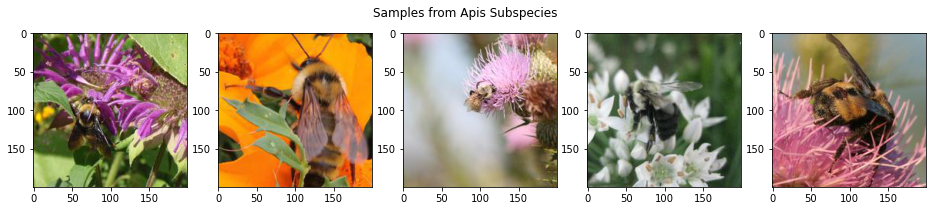

In [20]:
# How many training files ? (for upper limit of choose random number)
out_of = len(os.listdir(train_apis_dir))

columns = 5 # How many images?

# Define Subplots
f, ax = plt.subplots(nrows=1,ncols=columns, figsize=(16,3))

# Plot 5 images
for k in range(columns):
    
    # Choose random number
    rand = np.random.randint(1,out_of)
    filename = train_apis_dir + '/' + str(rand) + '.jpg'
    # Read and Show Image
    im=imageio.imread(filename)
    ax[k].imshow(im, resample=True)
    
plt.suptitle("Samples from Apis Subspecies")

Text(0.5, 0.98, 'Samples from Bombus Subspecies')

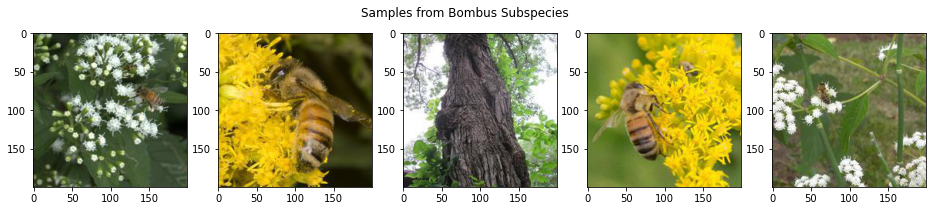

In [21]:
# Define Subplots
f_t, ax_t = plt.subplots(nrows=1,ncols=columns, figsize=(16,3))

for k in range(columns):
    
    # Choose random number
    rand = np.random.randint(1,out_of)
    filename = train_bombus_dir + '/' + str(rand) + '.jpg'
    # Read and Show Image
    im=imageio.imread(filename)
    ax_t[k].imshow(im, resample=True)
    
plt.suptitle("Samples from Bombus Subspecies")

# Chapter 2:  Setting up training and validation Pipelines

In this chapter, we will set up pipelines for model training and test using **Keras**. For reference on how the setup works, one may refer the [Keras website](https://keras.io/api/preprocessing/image/). Before setting up the pipeline, we will also rescale all the images to a scale of 1/255. 

In [22]:
image_size = 50 # All images will be resized to 50*50
epochs = 10
batch_size = 16

train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale= 1/255)
test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale= 1/255)

#Flow training images in batches of 16 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
                train_dir,  # Source directory for the training images
                target_size=(image_size, image_size),
                batch_size=batch_size,
                # Since we use binary_crossentropy loss, we need binary labels
                class_mode='binary')

# Flow validation images in batches of 16 using test_datagen generator
test_generator = test_datagen.flow_from_directory(
                test_dir, # Source directory for the validation images
                target_size=(image_size, image_size),
                batch_size=batch_size,
                class_mode='binary')

Found 1000 images belonging to 2 classes.
Found 250 images belonging to 2 classes.


# Chapter 3: Setting up Model with base as VGG16 CNN.


We will create the base model from the [VGG16](https://arxiv.org/pdf/1409.1556.pdf) model, and pre-trained on the [ImageNet](http://image-net.org/challenges/LSVRC/) dataset, a large dataset of 1.4M images and 1000 classes of web images. This is a powerful model. Let's see what the features that it has learned can do for our Bee classification.


You can find more pretrained and ready to load models [here](https://www.tensorflow.org/api_docs/python/tf/keras/applications).

**Feature Extraction:** A common practice is to use the output of the very last layer before the flatten operation, the so-called "bottleneck layer". The reason here is that the following fully-connected layers will be too specialized to the task the network was trained on, and thus the features learned by these layers won't be very useful for a new task. The bottleneck features, however, retain much generality.


Let's store a VGG16 model pre-loaded with weights trained on ImageNet. By specifying the **include_top=False** argument, we load a network that doesn't include the classification layers, which is ideal for feature extraction.

In [23]:
IMG_SHAPE = (image_size, image_size, 3)

# Ref: https://www.tensorflow.org/api_docs/python/tf/keras/applications/VGG16

# Create the base model from the pre-trained model MobileNet V2
feature_extractor = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                                include_top=False,
                                                weights='imagenet')


## Feature Extraction

We will freeze the layers of the VGG16 and utilize the capabilities of this part of the network. By adding a classification layer on top of it and training the top-level classifier on our data we repurpose the pretrained model.
Freezing means keeping the respective weights from updating in the weight update phase of the training process.

In [24]:
# Refer: https://keras.io/guides/transfer_learning/

feature_extractor.trainable = False # boolean, freezes the layer

# Let's take a look at the base model architecture (notice the amount of non-trainable params)
feature_extractor.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 50, 50, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 50, 50, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 50, 50, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 25, 25, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 25, 25, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 25, 25, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0     

## Adding Last Layer

As expected due to the above set Boolean parameter, all parameters of the model shown above are **blocked** for training. Therefore, we see 0 paramaters as Trainable. Now we are adding a classification layer to the base model. We will set the activation function of this layer as **sigmoid** function as it gives us the probability of each class involved. We add Global Average Pooling Layer to prevent overfitting of immense number of parameters. Compile the newly combined model. We will see that only the parameters of this last layer are trainable during the training phase.


In [25]:
# Add an avergaing pooling layer and one dense to above extracted model.
model = tf.keras.Sequential([
        feature_extractor,
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dense(1, activation='sigmoid')])

# Compile Model
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.01),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Show model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 14,715,201
Trainable params: 513
Non-trainable params: 14,714,688
_________________________________________________________________


# Chapter 4: Training the Model from Chapter 3 using Transfer Learning.

Now that we have defined the training dataset and the model, we can start the training process of the model. The training will be done in batch size of 16 and total of 10 Epochs will be carried out. After each epoch, the tranined parameters are saved in the defined checkpoint file. For this we need to define a callback function that can be passed as an argument to the training function. This callback function defines the directory and the filename in which the parameters are stored. If anything goes wrong during the training process, these checkpoint files will serve as a backup to the amount of work done till the problem came. For more info on this topic, one may refer the [TensorFlow Checkpoint](https://www.tensorflow.org/guide/checkpoint) webpage.

In [43]:
# Saving the model
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'

# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_training_vgg16")

# Checkpoint Callback
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

# Training Parameters
epochs = 10
steps_per_epoch = train_generator.n // batch_size
validation_steps = test_generator.n // batch_size

# Train model
history = model.fit(train_generator,
                              steps_per_epoch = steps_per_epoch,
                              epochs=epochs,
                              validation_data=test_generator,
                              validation_steps=validation_steps,
                              callbacks=[checkpoint_callback])

Epoch 1/10
62/62 [==============================] - 8s 129ms/step - loss: 0.4456 - accuracy: 0.7917 - val_loss: 0.5681 - val_accuracy: 0.7333
Epoch 2/10
62/62 [==============================] - 8s 134ms/step - loss: 0.4319 - accuracy: 0.8089 - val_loss: 0.6376 - val_accuracy: 0.7125
Epoch 3/10
62/62 [==============================] - 8s 135ms/step - loss: 0.4365 - accuracy: 0.8059 - val_loss: 0.5903 - val_accuracy: 0.7083
Epoch 4/10
62/62 [==============================] - 9s 152ms/step - loss: 0.4156 - accuracy: 0.8181 - val_loss: 0.6213 - val_accuracy: 0.7000
Epoch 5/10
62/62 [==============================] - 9s 139ms/step - loss: 0.4126 - accuracy: 0.8181 - val_loss: 0.6278 - val_accuracy: 0.7042
Epoch 6/10
62/62 [==============================] - 8s 134ms/step - loss: 0.4110 - accuracy: 0.8171 - val_loss: 0.6036 - val_accuracy: 0.7375
Epoch 7/10
62/62 [==============================] - 8s 130ms/step - loss: 0.4094 - accuracy: 0.8110 - val_loss: 0.6292 - val_accuracy: 0.7167
Epoch 

## Plotting Training Loss and Accuracy

TensorFlow facilitates the training loss and the accuracy of the model during each epoch. This information is stored as the history and can be accessed for visualization. We will plot the graphs of **loss** and **accuracy** for each epoch and see that the loss decreases with time whereas the accuracy of the model consistently increases with time.

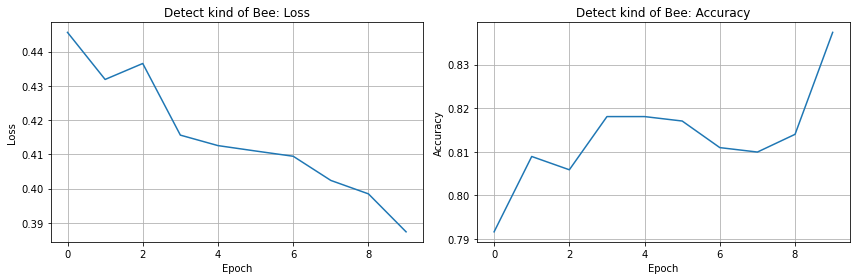

In [44]:
## Trained model analysis and evaluation
f, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(history.history['loss'])
ax[0].set_title('Detect kind of Bee: Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].grid()


# Accuracy
ax[1].plot(history.history['accuracy'])
ax[1].set_title('Detect kind of Bee: Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
plt.tight_layout()
ax[1].grid()
plt.show()

## Evaluation

After the model is trained, it is then evaluated on the **test_generator** (the part of dataset we use for validation.) The result of the evaluation gives us the loss value as well as the accuracy. We see that the accuracy of the trained model is about 0.71 which is pretty good given that the training time required to achieve this accuracy is about just 90 seconds.

In [45]:
# Model Evaluation: Loss and Accuracy

test_res = model.evaluate(test_generator, steps=None, callbacks=None, max_queue_size=10, workers=1,
                                    use_multiprocessing=False, verbose=0)
print('Evaluation: loss function: %s, accuracy:' % test_res[0], test_res[1])

Evaluation: loss function: 0.6222507953643799, accuracy: 0.7120000123977661


## Visualize Kernels

Let's look how our models process images. Our models contains Conv2D layers with kernels inside. We are going to convolve a sample image through a few kernels of the first layer and see how does it look before and after each kernel. For each kernel visualization, we require: kernel itself (shown in the left pane), input image (shown in the middle pane), output image (shown in the right pane). By looking at the convolved images, we can interpret what type of feautures the model tries to learn. Although, a little information is available directly with such visualization, one may still refer to work done by Google AI labs (or a [summary](https://github.com/sa32953/lero/blob/master/feature_visualization/32953_Sahil_Arora_Feature_Visualization_Presentation.pdf) prepared by me) to better understand the importance. 

In [29]:
import scipy
from scipy.ndimage import filters

In [30]:
# Common function for visualization of kernels
def visualize_layer_kernels(img, conv_layer, title):
    """
    Displays how input sample image looks after convolution by each kernel
    :param img: Sample image array
    :param conv_layer: Layer of Conv2D type
    :param title: Text to display on the top 
    """
    # Extract kernels from given layer
    weights1 = conv_layer.get_weights()
    kernels = weights1[0]
    
    # Limit to 5 images only
    kernels_num = 5
    
    # Each row contains 3 images: kernel, input image, output image
    f, ax = plt.subplots(kernels_num, 3, figsize=(12, kernels_num*2))

    for i in range(0, kernels_num):
        # Get kernel from the layer and draw it
        kernel=kernels[:,:,:3,i]
        ax[i][0].imshow((kernel * 255).astype(np.uint8), vmin=0, vmax=255)
        ax[i][0].set_title("Kernel %d" % i, fontsize = 9)
        
        # Get and draw sample image from test data
        ax[i][1].imshow((img).astype(np.uint8), vmin=0, vmax=255)
        ax[i][1].set_title("Before", fontsize=8)
        
        # Filtered image - apply convolution
        img_filt = filters.convolve(img, kernel)
        ax[i][2].imshow((img_filt * 255).astype(np.uint8), vmin=0, vmax=255)
        ax[i][2].set_title("After", fontsize=8)
        
    plt.suptitle(title)
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    plt.show()   

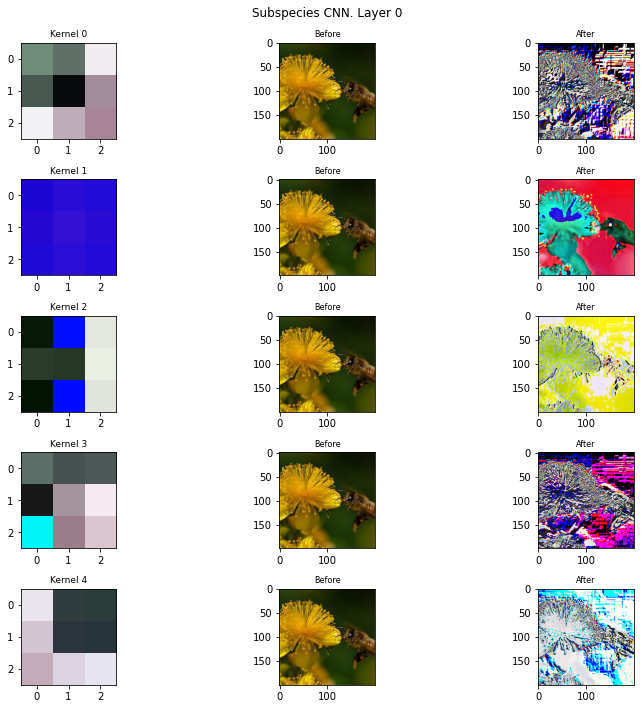

In [31]:
rand = np.random.randint(1,125)
filename = train_bombus_dir + '/' + str(rand) + '.jpg'
img = imageio.imread(filename)

# Take 1st convolutional layer and look at some of its filters
conv1 = model.layers[0]
img = visualize_layer_kernels(img, conv1, "Subspecies CNN. Layer 0")

# Chapter 5: Setting up a fully trainable model of VGG16 size.

In this Chapter, we will not use Transfer Learning, rather we will use the full VGG16 model to train. The steps of extraction of VGG16 model will remain same as in Chapters 3 and 4. An exactly same top layer will be added to the extracted model (with a Global Averaging layer and classification using Sigmoid function). **Note the here, the boolean for training extracted model is set to True.** One can confirm this by seeing the number of trainable parameters in the model summary.

In [32]:
# Take VGG16 model from TensorFlow

sc_feature_extractor = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                                include_top=False,
                                                weights='imagenet')

sc_feature_extractor.trainable = True # boolean, unfreezes the layer

In [33]:
# Add a Global Averaging Pooling layer to extracted model
# Add a sigmoid classification layer to the model

sc_model = tf.keras.Sequential([
        sc_feature_extractor,
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dense(1, activation='sigmoid')])

# Compile Model
sc_model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.01),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Show model summary
sc_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 14,715,201
Trainable params: 14,715,201
Non-trainable params: 0
_________________________________________________________________


# Chapter 6: Training the model from scratch.

Now that we have defined the model, we can start the training process of the model. The training will be done in batch size of 16 and total of 10 Epochs will be carried out. After each epoch, the tranined parameters are saved in the defined checkpoint file. For this we need to define a callback function that can be passed as an argument to the training function. This callback function defines the directory and the filename in which the parameters are stored. If anything goes wrong during the training process, these checkpoint files will serve as a backup to the amount of work done till the problem came. For more info on this topic, one may refer the [TensorFlow Checkpoint](https://www.tensorflow.org/guide/checkpoint) webpage.

In [34]:
# Saving the model
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'

# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_training_scratch_model")

# Checkpoint Callback
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

# Training Parameters
epochs = 10
steps_per_epoch = train_generator.n // batch_size
validation_steps = test_generator.n // batch_size

# Train model
sc_history = sc_model.fit_generator(train_generator,
                              steps_per_epoch = steps_per_epoch,
                              epochs=epochs,
                              validation_data=test_generator,
                              validation_steps=validation_steps,
                              callbacks=[checkpoint_callback])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
62/62 [==============================] - 42s 675ms/step - loss: 6726732480512.0000 - accuracy: 0.5081 - val_loss: 0.6968 - val_accuracy: 0.5125
Epoch 2/10
62/62 [==============================] - 44s 702ms/step - loss: 4.8475 - accuracy: 0.4756 - val_loss: 0.6931 - val_accuracy: 0.5042
Epoch 3/10
62/62 [==============================] - 44s 710ms/step - loss: 0.9266 - accuracy: 0.4980 - val_loss: 0.7040 - val_accuracy: 0.4917
Epoch 4/10
62/62 [==============================] - 43s 696ms/step - loss: 1.8930 - accuracy: 0.5081 - val_loss: 0.7221 - val_accuracy: 0.5000
Epoch 5/10
62/62 [==============================] - 46s 734ms/step - loss: 0.7934 - accuracy: 0.5041 - val_loss: 0.6938 - val_accuracy: 0.4958
Epoch 6/10
62/62 [==============================] - 48s 770ms/step - loss: 216.2183 - accuracy: 0.5000 - val_loss: 0.7010 - val_accuracy: 0.5042
Epoch 7/10
62/62 [==============================] - 

## Plotting training Loss and Accuracy

TensorFlow facilitates the training loss and the accuracy of the model during each epoch. This information is stored as the history and can be accessed for visualization. We will plot the graphs of **loss** and **accuracy** for each epoch and see that the loss decreases with time whereas the accuracy of the model consistently increases with time. We observe that although the training time is very high, the accuracy revolves pretty much around 0.5 which is not so good.

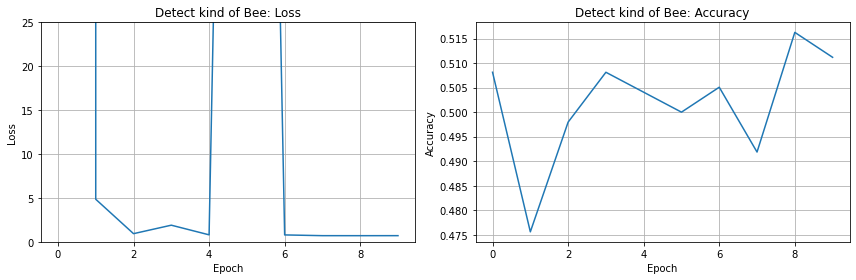

In [41]:
## Trained model analysis and evaluation
f, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(sc_history.history['loss'])
ax[0].set_title('Detect kind of Bee: Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_ylim(0,25)
ax[0].grid()


# Accuracy
ax[1].plot(sc_history.history['accuracy'])
ax[1].set_title('Detect kind of Bee: Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
plt.tight_layout()
ax[1].grid()
plt.show()

### Evaluation

After the model is trained, it is then evaluated on the **test_generator** (the part of dataset we use for validation.) The result of the evaluation gives us the loss value as well as the accuracy. We see that the accuracy of the trained model is about 0.5 which is not so good.

In [31]:
# Model Evaluation: Loss and Accuracy

sc_test_res = sc_model.evaluate_generator(test_generator, steps=None, callbacks=None, max_queue_size=10, workers=1,
                                    use_multiprocessing=False, verbose=0)
print('Evaluation: loss function: %s, accuracy:' % sc_test_res[0], sc_test_res[1])

Evaluation: loss function: 0.7041470408439636, accuracy: 0.5


# Chapter 7: Comparing the results of Transfer Learning and Learning from scratch.

### Result: We saw that Tranfer Learning took just 90 seconds for the complete training process. On the other hand training from scratch took around 450 seconds. Training from scratch took 5 times more time than Transfer Learning. No doubt that Transfer Learning will be the choice if jsut time is concerned. Moreover, the accuracy on the test data achieved with Transfer Learning is far better in our case. It may happen that training rom scratch will give us better results under a different model configuration but again it may take up larger time to train.

### So the question is why would anyone train from scratch ?

Transfer learning make sense only if some certain conditions are fulfilled: 
1. We can use the pretrained model only if the source task and target task are related. Using a model trained on KITTI for new task of detecting potholes on German roads make sense. But using the same set on classification of Birds may not be that good an idea.
2. Also, we use TF when the source dataset is so big that it can be called as a 'generalization'. If Target dataset has comparable number of images than it may be a good idea to spend time on training from scratch.